In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    import geopandas as gpd
    import shapefile
    from osgeo import ogr,osr,gdal
except:
    !pip install geopandas
    !pip install PyShp
    !pip install gdal
import geopandas as gpd
import shapefile
import numpy as np
import pandas as pd
import xarray as xr
import os
import time
from osgeo import ogr,osr,gdal
import tensorflow as tf
import io
import ee, folium

In [ ]:
import ee, folium
ee.Authenticate()
ee.Initialize(project='ee-manmeet20singh15-wbis')

In [ ]:
!pip install timm
!pip install wxee
import wxee
wxee.Initialize()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
df = pd.read_excel('drive/MyDrive/Shivam/Long_DMSP_NDUI/US_DOE_SW_IFL_cities.xlsx')
df

,Name,lat,lon
0,Baltimore,39.2904,-76.6122
1,Chicago,41.8781,-87.6298
2,Beaumount,30.0802,-94.1266


In [ ]:
!nvidia-smi

Tue Apr 16 17:18:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Make directory with city name

In [ ]:
# cities_folder = 'drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities'
# os.mkdir(cities_folder)

# for city in city_names:
#   city_folder = os.path.join(cities_folder, city)
#   os.mkdir(city_folder)

In [ ]:
city_name=[]
for i in range(len(df.Name)):
  city = str(df.Name[i])
  city_name.append(city)
city_name

['Baltimore', 'Chicago', 'Beaumount']

In [ ]:
cities_folder = 'drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities'
city_path =[]
for i in range(len(city_name)):
  path = os.path.join(cities_folder, city_name[i])
  city_path.append(path)
city_path

['drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/Baltimore',
 'drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/Chicago',
 'drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/Beaumount']

In [ ]:
ls drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/Baltimore

best_model_Baltimore.pth     dmsp_2013_2022_Baltimore.nc
dmsp_1992_2012_Baltimore.nc  dmsp_swinIR_1992_2022_Baltimore.nc


In [ ]:
dmsp_swinIR_city = []
for i in range(len(city_name)):
  dmsp_c = xr.open_dataset(str(city_path[i])+'/dmsp_swinIR_1992_2022_'+str(city_name[i]+'.nc'))
  dmsp_swinIR_city.append(dmsp_c)
dmsp_swinIR_city[0]

<xarray.Dataset>
Dimensions:  (lat: 600, lon: 600, time: 31)
Coordinates:
  * lat      (lat) float64 41.82 41.81 41.8 41.8 ... 36.85 36.85 36.84 36.83
  * lon      (lon) float64 -79.11 -79.1 -79.1 -79.09 ... -74.14 -74.13 -74.12
  * time     (time) datetime64[ns] 1992-01-01 1993-01-01 ... 2022-01-01
Data variables:
    dmsp     (time, lat, lon) float64 ...

In [ ]:
aoi_city = []
for i in range(len(df.lat)):
  lats, late = df.lat[i]-0.20, df.lat[i]+0.20
  lons, lone = df.lon[i]-0.20, df.lon[i]+0.20
  aoi = ee.Geometry.Polygon(
        [[[lons, lats],
          [lone, lats],
          [lone, late],
          [lons, late]]])
  aoi_city.append(aoi)
aoi_city[2]

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -94.3266,
              29.880200000000002
            ],
            [
              -93.9266,
              29.880200000000002
            ],
            [
              -93.9266,
              30.2802
            ],
            [
              -94.3266,
              30.2802
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})

In [ ]:
coords = aoi_city[0].coordinates().getInfo()[0]
coords

[[-76.8122, 39.090399999999995],
 [-76.4122, 39.090399999999995],
 [-76.4122, 39.4904],
 [-76.8122, 39.4904],
 [-76.8122, 39.090399999999995]]

In [ ]:
for i in range(2):
    print(i)

0
1


## Long NDUI

In [ ]:
# ndui_1999_2022_albuquerque
dates = pd.date_range('1999', '2022', freq='YS')
ndui_city = []
for i in range(2):
    print(city_name[i])
    ndui_c_ = []
    for year_ in range(1999,2023):
        print(year_)
        year = str(year_)#'1999'
        # ds_dmsp_interp = ds_dmsp.sel(time=slice(year, year)).interp(lon=ds_ndvi.x, lat=ds_ndvi.y).dmsp.values[0,:,:]/63.0
        # L7 = ee.ImageCollection('LE7_L1T_TOA').filterDate(year+'-01-01', year+'-12-31')
        if year_ == 1999:
            L7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA").filterDate(str(year_)+'-01-01', str(year_+2)+'-12-31')
            print(year_)
            print(str(year_)+'-01-01', str(year_+2)+'-12-31')
        elif year_ == 2000:
            L7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA").filterDate(str(year_-1)+'-01-01', str(year_+1)+'-12-31')
            print(year_)
            print(str(year_-1)+'-01-01', str(year_+1)+'-12-31')
        else:
            L7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_TOA").filterDate(str(year_-2)+'-01-01', str(year_)+'-12-31')
            print(year_)
            print(str(year_-2)+'-01-01', str(year_)+'-12-31')

        def fun4(img):
            bad1 = img.select('B1').eq(0.0)
            bad2 = img.select('B2').eq(0.0)
            bad3 = img.select('B3').eq(0.0)
            bad4 = img.select('B4').eq(0.0)
            bad5 = img.select('B5').eq(0.0)
            bad7 = img.select('B7').eq(0.0)
            mask = img.mask().And(bad1.Or(bad2).Or(bad3).Or(bad4).Or(bad5).Or(bad7).Not())
            #var mask = img.select('10','20','30','40','50','70').mask().reduce('product').eq(1);
            masked = img.mask(mask);
            ndvi = masked.normalizedDifference(["B4","B3"])
            return ndvi

        NDVIs = L7.map(fun4)

        Mean_NDVI = NDVIs.median()
        Max_NDVI = NDVIs.max()
        Min_NDVI = NDVIs.min()
        mosaic = Mean_NDVI.where(Max_NDVI.gt(0.4), Max_NDVI)
        mosaic = mosaic.where(Min_NDVI.lt(-0.2), Min_NDVI)

        mosaic = mosaic.set('system:time_start', 0)
        ds_ndvi_c = mosaic.wx.to_xarray(region=aoi_city[i].bounds(), scale=30)
        ds_ndvi_c_ = ds_ndvi_c.nd.values[0,:,:]
        ds_dmsp_interp_c = dmsp_swinIR_city[i].sel(time=slice(year, year)).interp(lon=ds_ndvi_c.x, lat=ds_ndvi_c.y).dmsp.values[0,:,:]/63.0
        # ds_ndvi_c_ = mosaic.wx.to_xarray(region=aoi_city[i].bounds(), scale=30).nd.values[0,:,:]

        ndui_c = (ds_dmsp_interp_c - ds_ndvi_c_)/(ds_dmsp_interp_c + ds_ndvi_c_)
        ndui_c[ndui_c>1.0] = 1.0
        ndui_c[ndui_c<-1.0] = -1.0
        ndui_c_.append(ndui_c)
    print(len(ndui_c_))
    print(np.stack(ndui_c_).shape)

    ndui_c_stack = np.stack(ndui_c_)
    ds_ndui_c = xr.Dataset({
        'ndui': xr.DataArray(
            data   = ndui_c_stack,   # enter data here
            dims   = ['time', 'lat', 'lon'],
            coords = {'time':dates, 'lat': ds_ndvi_c.y.values, 'lon': ds_ndvi_c.x.values},
            ),
        },
                                               )
    print(ds_ndui_c)
    ndui_city.append(ds_ndui_c)
ndui_city[0]

Baltimore
1999
1999
1999-01-01 2001-12-31


Downloading:   0%|          | 0.00/5.08M [00:00<?, ?iB/s]

2000
2000
1999-01-01 2001-12-31


Downloading:   0%|          | 0.00/5.08M [00:00<?, ?iB/s]

2001
2001
1999-01-01 2001-12-31


Downloading:   0%|          | 0.00/5.08M [00:00<?, ?iB/s]

2002
2002
2000-01-01 2002-12-31


Downloading:   0%|          | 0.00/5.07M [00:00<?, ?iB/s]

2003
2003
2001-01-01 2003-12-31


Downloading:   0%|          | 0.00/4.87M [00:00<?, ?iB/s]

2004
2004
2002-01-01 2004-12-31


Downloading:   0%|          | 0.00/4.96M [00:00<?, ?iB/s]

2005
2005
2003-01-01 2005-12-31


Downloading:   0%|          | 0.00/5.02M [00:00<?, ?iB/s]

2006
2006
2004-01-01 2006-12-31


Downloading:   0%|          | 0.00/5.11M [00:00<?, ?iB/s]

2007
2007
2005-01-01 2007-12-31


Downloading:   0%|          | 0.00/5.14M [00:00<?, ?iB/s]

2008
2008
2006-01-01 2008-12-31


Downloading:   0%|          | 0.00/5.15M [00:00<?, ?iB/s]

2009
2009
2007-01-01 2009-12-31


Downloading:   0%|          | 0.00/5.10M [00:00<?, ?iB/s]

2010
2010
2008-01-01 2010-12-31


Downloading:   0%|          | 0.00/5.06M [00:00<?, ?iB/s]

2011
2011
2009-01-01 2011-12-31


Downloading:   0%|          | 0.00/5.00M [00:00<?, ?iB/s]

2012
2012
2010-01-01 2012-12-31


Downloading:   0%|          | 0.00/4.93M [00:00<?, ?iB/s]

2013
2013
2011-01-01 2013-12-31


Downloading:   0%|          | 0.00/4.95M [00:00<?, ?iB/s]

2014
2014
2012-01-01 2014-12-31


Downloading:   0%|          | 0.00/4.90M [00:00<?, ?iB/s]

2015
2015
2013-01-01 2015-12-31


Downloading:   0%|          | 0.00/5.02M [00:00<?, ?iB/s]

2016
2016
2014-01-01 2016-12-31


Downloading:   0%|          | 0.00/5.02M [00:00<?, ?iB/s]

2017
2017
2015-01-01 2017-12-31


Downloading:   0%|          | 0.00/5.14M [00:00<?, ?iB/s]

2018
2018
2016-01-01 2018-12-31


Downloading:   0%|          | 0.00/5.09M [00:00<?, ?iB/s]

2019
2019
2017-01-01 2019-12-31


Downloading:   0%|          | 0.00/5.06M [00:00<?, ?iB/s]

2020
2020
2018-01-01 2020-12-31


Downloading:   0%|          | 0.00/4.97M [00:00<?, ?iB/s]

2021
2021
2019-01-01 2021-12-31


Downloading:   0%|          | 0.00/5.13M [00:00<?, ?iB/s]

2022
2022
2020-01-01 2022-12-31


Downloading:   0%|          | 0.00/5.17M [00:00<?, ?iB/s]

24
(24, 1486, 1486)
<xarray.Dataset>
Dimensions:  (time: 24, lat: 1486, lon: 1486)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 2000-01-01 ... 2022-01-01
  * lat      (lat) float64 39.49 39.49 39.49 39.49 ... 39.09 39.09 39.09 39.09
  * lon      (lon) float64 -76.81 -76.81 -76.81 -76.81 ... -76.41 -76.41 -76.41
Data variables:
    ndui     (time, lat, lon) float64 -0.0653 -0.07069 -0.07177 ... -1.0 -1.0
Chicago
1999
1999
1999-01-01 2001-12-31


Downloading:   0%|          | 0.00/4.03M [00:00<?, ?iB/s]

2000
2000
1999-01-01 2001-12-31


Downloading:   0%|          | 0.00/4.03M [00:00<?, ?iB/s]

2001
2001
1999-01-01 2001-12-31


Downloading:   0%|          | 0.00/4.03M [00:00<?, ?iB/s]

2002
2002
2000-01-01 2002-12-31


Downloading:   0%|          | 0.00/4.27M [00:00<?, ?iB/s]

2003
2003
2001-01-01 2003-12-31


Downloading:   0%|          | 0.00/4.12M [00:00<?, ?iB/s]

2004
2004
2002-01-01 2004-12-31


Downloading:   0%|          | 0.00/4.14M [00:00<?, ?iB/s]

2005
2005
2003-01-01 2005-12-31


Downloading:   0%|          | 0.00/4.15M [00:00<?, ?iB/s]

2006
2006
2004-01-01 2006-12-31


Downloading:   0%|          | 0.00/4.35M [00:00<?, ?iB/s]

2007
2007
2005-01-01 2007-12-31


Downloading:   0%|          | 0.00/4.35M [00:00<?, ?iB/s]

2008
2008
2006-01-01 2008-12-31


Downloading:   0%|          | 0.00/4.36M [00:00<?, ?iB/s]

2009
2009
2007-01-01 2009-12-31


Downloading:   0%|          | 0.00/4.37M [00:00<?, ?iB/s]

2010
2010
2008-01-01 2010-12-31


Downloading:   0%|          | 0.00/4.38M [00:00<?, ?iB/s]

2011
2011
2009-01-01 2011-12-31


Downloading:   0%|          | 0.00/4.28M [00:00<?, ?iB/s]

2012
2012
2010-01-01 2012-12-31


Downloading:   0%|          | 0.00/4.36M [00:00<?, ?iB/s]

2013
2013
2011-01-01 2013-12-31


Downloading:   0%|          | 0.00/4.31M [00:00<?, ?iB/s]

2014
2014
2012-01-01 2014-12-31


Downloading:   0%|          | 0.00/4.31M [00:00<?, ?iB/s]

2015
2015
2013-01-01 2015-12-31


Downloading:   0%|          | 0.00/4.23M [00:00<?, ?iB/s]

2016
2016
2014-01-01 2016-12-31


Downloading:   0%|          | 0.00/4.25M [00:00<?, ?iB/s]

2017
2017
2015-01-01 2017-12-31


Downloading:   0%|          | 0.00/4.28M [00:00<?, ?iB/s]

2018
2018
2016-01-01 2018-12-31


Downloading:   0%|          | 0.00/4.38M [00:00<?, ?iB/s]

2019
2019
2017-01-01 2019-12-31


Downloading:   0%|          | 0.00/4.34M [00:00<?, ?iB/s]

2020
2020
2018-01-01 2020-12-31


Downloading:   0%|          | 0.00/4.28M [00:00<?, ?iB/s]

2021
2021
2019-01-01 2021-12-31


Downloading:   0%|          | 0.00/4.26M [00:00<?, ?iB/s]

2022
2022
2020-01-01 2022-12-31


Downloading:   0%|          | 0.00/4.22M [00:00<?, ?iB/s]

24
(24, 1486, 1485)
<xarray.Dataset>
Dimensions:  (time: 24, lat: 1486, lon: 1485)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 2000-01-01 ... 2022-01-01
  * lat      (lat) float64 42.08 42.08 42.08 42.08 ... 41.68 41.68 41.68 41.68
  * lon      (lon) float64 -87.83 -87.83 -87.83 -87.83 ... -87.43 -87.43 -87.43
Data variables:
    ndui     (time, lat, lon) float64 0.2277 0.2249 0.2249 ... 1.0 1.0 1.0


<xarray.Dataset>
Dimensions:  (time: 24, lat: 1486, lon: 1486)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 2000-01-01 ... 2022-01-01
  * lat      (lat) float64 39.49 39.49 39.49 39.49 ... 39.09 39.09 39.09 39.09
  * lon      (lon) float64 -76.81 -76.81 -76.81 -76.81 ... -76.41 -76.41 -76.41
Data variables:
    ndui     (time, lat, lon) float64 -0.0653 -0.07069 -0.07177 ... -1.0 -1.0

In [ ]:
for i in range(2):
  ndui_city[i].to_netcdf('drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/'+str(city_name[i])+'/ndui_1992_2022_'+str(city_name[i]+'.nc'))
!ls drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/Baltimore

best_model_Baltimore.pth     dmsp_2013_2022_Baltimore.nc	 ndui_1992_2022_Baltimore.nc
dmsp_1992_2012_Baltimore.nc  dmsp_swinIR_1992_2022_Baltimore.nc


In [ ]:
!ls drive/MyDrive/Shivam/Long_DMSP_NDUI/Cities/Chicago

best_model_Chicago.pth	   dmsp_2013_2022_Chicago.nc	     ndui_1992_2022_Chicago.nc
dmsp_1992_2012_Chicago.nc  dmsp_swinIR_1992_2022_Chicago.nc


In [ ]:
ndui_city[1]

<xarray.Dataset>
Dimensions:  (time: 24, lat: 1486, lon: 1485)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 2000-01-01 ... 2022-01-01
  * lat      (lat) float64 42.08 42.08 42.08 42.08 ... 41.68 41.68 41.68 41.68
  * lon      (lon) float64 -87.83 -87.83 -87.83 -87.83 ... -87.43 -87.43 -87.43
Data variables:
    ndui     (time, lat, lon) float64 0.2277 0.2249 0.2249 ... 1.0 1.0 1.0

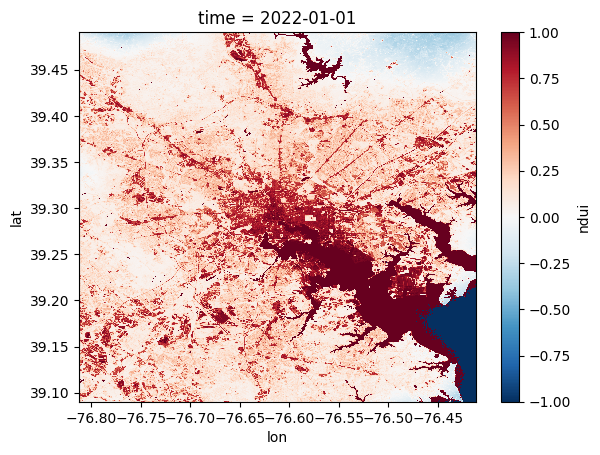

In [ ]:
ndui_city[0].ndui.isel(time=-1).plot()

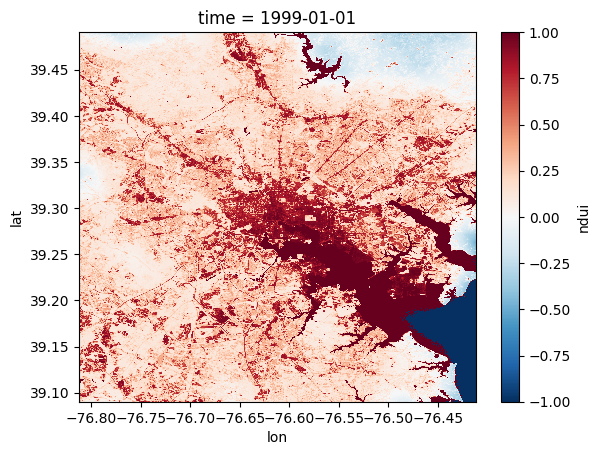

In [ ]:
ndui_city[0].ndui.isel(time=0).plot()

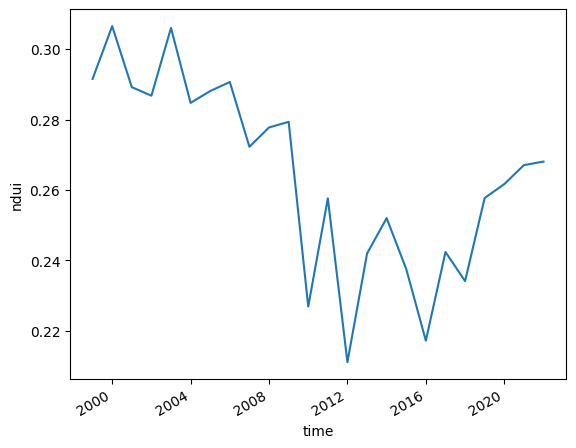

In [ ]:
ndui_city[0].ndui.mean(dim='lat').mean(dim='lon').plot()

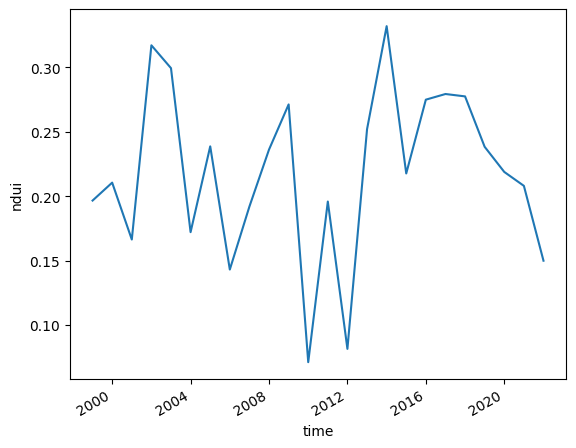

In [ ]:
ndui_city[1].ndui.mean(dim='lat').mean(dim='lon').plot()